In [1]:
import calendar
import gzip
import io
import json
import os
import re
import tarfile
from datetime import date
from typing import Dict, List, Union

import graphistry
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import umap
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from torch import Tensor

sns.set(style='white', context='poster')

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

Part 1: Knowledge Graph Construction
====================================

In this section of the course, we will cover _knowledge graph construction_ or how to construct knowledge graphs from both _natural networks_ and _structural networks_. In the lecture I described _knowledge graph construction_ as the process of building a knowledge graph from raw data using ETL, data transformations or Natural Language Processing (NLP).

There are two main types of networks in common use: simple and heterogeneous networks. We're going to start out building a simple network where nodes are _academic papers_ and edges are _citations between papers_.

<center><img src="images/Graphs-vs-Heterogeneous-Graphs-2000px.png" width="1000px" /></center>

There are two categories of data from which we can build networks: _natural networks_ and _structural networks_. We can also transform _existing networks_ that are already formatted and easy to work with.

<center><img src="images/ETL-in-Natural-and-Structural-Graphs.jpg" width="860px" /></center>

Structural networks are just as important as natural networks because...

<center><img src="images/Raw-Data-are-Often-Not-Networks.png" width="960px" /></center>
<center>Slide on Network Construction from <a href="https://scholar.google.com/citations?user=Q_kKkIUAAAAJ&hl=en&oi=ao">Jure Leskovec's</a> <a href="https://web.stanford.edu/class/cs224w/">Stanford CS224W class</a> when it was still called <i>Network Analysis</i>. Today it is called <i>Machine Learning with Graphs</i></center>

<br />

Given time, we'll be building both _simple_ and _heterogeneous networks_ from both _natural_ and _structural graphs_. We'll start with the former.

# Section Textbook

An excellent resource for the first two parts of this course, **Knowledge Graph Construction** and **Network Science** is the [Network Science (CC4063 / CC4095)](https://www.dcc.fc.up.pt/~pribeiro/aulas/ns2122/) class taught by [Pedro Ribeiro](https://www.dcc.fc.up.pt/~pribeiro/) at the [Center for Research in Advanced Computing Systems](https://cracs.fc.up.pt/), part of the [Computer Science Department](https://www.dcc.fc.up.pt/site/) of the [University of Porto](https://www.up.pt/portal/en/).

We will be using [Section 10: Network Construction](https://www.dcc.fc.up.pt/~pribeiro/aulas/ns2122/handouts.html#construction) during this part of the course, and specifically the slides for that section: [Network Construction (selected slides from J. Leskovec and L. Lacasa)](https://www.dcc.fc.up.pt/~pribeiro/aulas/ns2122/10_netconstruction.pdf).

# Setting up Graphistry

First let's setup a network visualization tool to help us evaluate what we are building. Throughout this part of the course we will be using `pygraphistry` and [Graphistry Hub](https://hub.graphistry.com/) [https://hub.graphistry.com/](https://hub.graphistry.com/) to visualize networks. Both are free for personal use and are powerful for visualizing networks large and small.

You can [signup](https://hub.graphistry.com/accounts/signup/) for a Graphistry account at [https://hub.graphistry.com/accounts/signup/](https://hub.graphistry.com/accounts/signup/). <b>You should use a username/password/email to get the required credentials</b>, although after that you can login with your Github or Google account.

<center><img src="images/graphistry_hub_registration.png" /></center>

Retain and use your credentials in the login form and in the environment variables in the next cell below. You should set the `GRAPHISTRY_USERNAME` and `GRAPHISTRY_PASSWORD` variables in the `env/graphistry.env` file, and then restart this docker container to pickup the new values.

<center><img src="images/graphistry_hub_homepage.png" /></center>

# ETL for a Simple, Natural Graph: High-energy Physics Theory Citation Network

We are going to start out by building a knowledge graph from an existing edge list and then add properties to it. We'll be using the [High-energy physics theory citation network](https://snap.stanford.edu/data/cit-HepTh.html) from [Stanford SNAP](https://snap.stanford.edu/index.html). SNAP has many large network datasets available in the [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/).

The dataset includes the following files, which we will combine:

* [Citation graph edge list](https://snap.stanford.edu/data/cit-HepTh.txt.gz) contains node ID pairs. Node IDs are standard paper identifiers. This will build the core structure of our network.
* [Paper metadata](cit-HepTh-abstracts.tar.gz) including abstracts. This will add propertis to our network.
* [Publishing dates on arXiv](https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz) will make our citation network a temporal [Directed-Acyclic-Graph (DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph) since one paper can't cite another before it is written and there are no reciprocal edges. While we don't focus on this, it does affect our analysis.

## Dataset Citation

```
Paper: hep-th/0002031
From: Maulik K. Parikh 
Date: Fri, 4 Feb 2000 17:04:51 GMT   (10kb)

Title: Confinement and the AdS/CFT Correspondence
Authors: D. S. Berman and Maulik K. Parikh
Comments: 12 pages, 1 figure, RevTeX
Report-no: SPIN-1999/25, UG-1999/42
Journal-ref: Phys.Lett. B483 (2000) 271-276
\\
  We study the thermodynamics of the confined and unconfined phases of
superconformal Yang-Mills in finite volume and at large N using the AdS/CFT
correspondence. We discuss the necessary conditions for a smooth phase
crossover and obtain an N-dependent curve for the phase boundary.
\\
```

In [2]:
# Environment variable setup
GRAPHISTRY_USERNAME = os.getenv("GRAPHISTRY_USERNAME")
GRAPHISTRY_PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")

In [3]:
graphistry.register(
    api=3,
    username=GRAPHISTRY_USERNAME,
    password=GRAPHISTRY_PASSWORD,
)

In [4]:
# Configuration for Graphistry
GRAPHISTRY_PARAMS = {
    "play": 600,
    "pointOpacity": 0.7,
    "edgeOpacity": 0.3,
    "edgeCurvature": 0.3,
    "showArrows": True,
    "gravity": 0.5,
}
FAVICON_URL = "https://graphlet.ai/assets/icons/favicon.ico"
LOGO = {"url": "https://graphlet.ai/assets/Branding/Graphlet%20AI.svg", "dimensions": {"maxWidth": 100, "maxHeight": 100}}

## `NetworkX` on PyPi is `networkx` in code is `nx`.

The convention we used above is to load NetworkX via `import networkx as nx` so we can use the shorthand `nx` to call its classes and algorithms.

## Numeric Node IDs

What follows is a demonstration of _knowledge graph construction_, which we covered in the lecture. A node/edge list was provided, but the IDs are not sequential... which a network sampling tool I hope to use called [littleballoffur](https://github.com/benedekrozemberczki/littleballoffur) requires. In fact many graph libraries require sequential IDs. We must transform the graph IDs, create a mapping back and forth and annotate the nodes with properties for both IDs.

## Build a Directional Graph (nx.DiGraph) from a CSV

The edge list is a `#` commented, space-delimited CSV. We will parse it, assign sequential IDs and build a [`nx.DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html).

### Download the Citation Edge List

First, we download the edge list and build the structure of the network: `(paper)-cited->(paper)`. Note that we cache the edge list so you can edit the code without having to re-download the data.

The edge list is located at [https://snap.stanford.edu/data/cit-HepTh.txt.gz](https://snap.stanford.edu/data/cit-HepTh.txt.gz) and is stored in `data/cit-HepTh.txt.gz`. We will read the file in its compressed state via the `gzip` builtin library.

In [5]:
# Download and load edges (citations) from `cit-HepTh.txt.gz`
edge_path = "data/cit-HepTh.txt.gz"
gzip_content = None

if os.path.exists(edge_path):
    print(f"Using existing citation graph edge file {edge_path}")
    gzip_content = open(edge_path, "rb")
else:
    print("Fetching citation graph edge file ...")
    response = requests.get(f"https://snap.stanford.edu/{edge_path}")
    gzip_content = io.BytesIO(response.content)

    print("Writing edge list to file {edge_path}")
    with open(edge_path, "wb") as f:
        f.write(response.content)
        print(f"Wrote downloaded edge file to {edge_path}")

Using existing citation graph edge file data/cit-HepTh.txt.gz


In [6]:
# Check the top 10 lines of our gzip text file
!zcat data/cit-HepTh.txt.gz | head -10

# Directed graph (each unordered pair of nodes is saved once): Cit-HepTh.txt 
# Paper citation network of Arxiv High Energy Physics Theory category
# Nodes: 27770 Edges: 352807
# FromNodeId	ToNodeId
1001	9304045
1001	9308122
1001	9309097
1001	9311042
1001	9401139
1001	9404151

gzip: stdout: Broken pipe


### Graph and Identifier Setup

We create directional a [`nx.DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html) because citations are inherently directional: from citer to cited. Note that whether we model them this way or not, citation graphs are temporal networks. The citing paper's publishing date must fall after cited paper's publishing date. We'll load publishing dates below.

We need to setup `file_to_net` and `net_to_file` dictionaries to map back and forth between the file format's identifiers and or own sequential identifiers we'll be assigning starting with 0.

In [7]:
# Initialize a directed graph
G = nx.DiGraph()

In [8]:
# We need to create sequential IDs starting from 0 for littleballoffur and DGL
file_to_net: Dict[int, int] = {}
net_to_file: Dict[int, int] = {}
current_idx = 0

### From Text to Graph



In [9]:
# Decompress the gzip content and build the edge list for our network
print("Building network structure ...")

# Note we reuse the `gzip_content` variable from the download cell. This is a weird way to do it :)
with gzip.GzipFile(fileobj=gzip_content) as f:

    # Iterate through the lines, using the `line_number` as an `edge_id` below.
    # They won't quite start at 0 owing to comments, but that's ok in the case of edges.
    for line_number, line in enumerate(f):
        line = line.decode("utf-8")

        # Ignore comment lines that start with '#'
        if not line.startswith("#"):
            # Source (citing), desstination (cited) papers
            citing_key, cited_key = line.strip().split("\t")

            # The edge list makes the paper ID an int, stripping 0001001 to 1001, for example
            citing_key, cited_key = int(citing_key), int(cited_key)

            # If the either of the paper IDs don't exist, make one
            for key in [citing_key, cited_key]:
                if key not in file_to_net:
                    # Build up an index that maps back and forth
                    file_to_net[key] = current_idx
                    net_to_file[current_idx] = key

                    # Bump the current ID
                    current_idx += 1

            # print(f"Citing key: {citing_key}, Cited key: {cited_key}")
            # print(f"Mapped key: {file_to_net[citing_key]}, Mapped key: {file_to_net[cited_key]}")

            G.add_edge(file_to_net[citing_key], file_to_net[cited_key], edge_id=line_number)

            # Conditionally set the keys on the nodes
            G.nodes[file_to_net[citing_key]]["file_id"] = citing_key
            G.nodes[file_to_net[citing_key]]["sequential_id"] = file_to_net[citing_key]

            G.nodes[file_to_net[cited_key]]["file_id"] = cited_key
            G.nodes[file_to_net[cited_key]]["sequential_id"] = file_to_net[cited_key]

print(f"Network built! It contains {G.number_of_nodes():,} nodes and {G.number_of_edges():,} edges.")

Building network structure ...
Network built! It contains 27,770 nodes and 352,807 edges.


## Node Properties from Abstract Metadata

In addition to the edge list, SNAP provides the paper's essential metadata in another file, which we will load to provide node properties and text embeddings for citation graph.

We are going to perform the following steps:

1) Download and cache the metadata to `data/cit-HepTh-abstracts.tar.gz`. Note that 1 file corresponds to one paper node's metadata.
2) Process the tarball file where one file corresponds to one node ID in the original file. See why we made or mappings `file_to_net` and `net_to_file`?
3) Assign node properties by parsing the fields of the record using traditional information extraction with regular expressions.
4) Use a sentence transformer paraphrase model to summarize the entire textual record and enable node comparison for journal label creation.

### Downloading the Abstract Metadata

Another file containing node metadata, including the abstracts, for about 90% of nodes in this network is provided at [https://snap.stanford.edu/data/cit-HepTh-abstracts.tar.gz](https://snap.stanford.edu/data/cit-HepTh-abstracts.tar.gz), which we will save to `data/cit-HepTh-abstracts.tar.gz`. This code works just like the edge list download code above.

In [10]:
# Download the abstracts from `cit-HepTh-abstracts.tar.gz`
print("Fetching paper abstracts ...")
abstract_path = "data/cit-HepTh-abstracts.tar.gz"
abstract_gzip_content = None

if os.path.exists(abstract_path):
    print(f"Using existing paper abstracts file {abstract_path}")
    with open(abstract_path, "rb") as f:
        abstract_gzip_content = io.BytesIO(f.read())
else:
    print("Downloading paper abbstracts ...")
    abstract_response = requests.get(f"https://snap.stanford.edu/{abstract_path}")
    abstract_gzip_content = io.BytesIO(abstract_response.content)

    print(f"Downloading abstract file to {abstract_path}")
    with open(abstract_path, "wb") as f:
        f.write(abstract_response.content)
        print(f"Wrote downloaded abstract file to {abstract_path}")

Fetching paper abstracts ...
Using existing paper abstracts file data/cit-HepTh-abstracts.tar.gz


### Manually Parsing Node Metadata

As a first pass let's use regular expressions in the Python `re` builtin library to extract each paper's fields so we can assign them as properties to our `nx.DiGraph` nodes.

Here is what a couple of **test documents** look like. This is corresponds to two files in our abstract tarball.

In [11]:
docs = [
"""------------------------------------------------------------------------------
\\
Paper: hep-th/9612115
From: Asato Tsuchiya <tsuchiya@theory.kek.jp>
Date: Wed, 11 Dec 1996 17:38:56 +0900   (20kb)
Date (revised): Tue, 31 Dec 1996 01:06:34 +0900

Title: A Large-N Reduced Model as Superstring
Authors: N. Ishibashi, H. Kawai, Y. Kitazawa and A. Tsuchiya
Comments: 29 pages, Latex, a footnote and references added, eq.(3.52)
corrected, minor corrections
Report-no: KEK-TH-503, TIT/HEP-357
Journal-ref: Nucl.Phys. B498 (1997) 467-491
\\
A matrix model which has the manifest ten-dimensional N=2 super Poincare
invariance is proposed. Interactions between BPS-saturated states are analyzed
to show that massless spectrum is the same as that of type IIB string theory.
It is conjectured that the large-N reduced model of ten-dimensional super
Yang-Mills theory can be regarded as a constructive definition of this model
and therefore is equivalent to superstring theory.
\\
""",
    """------------------------------------------------------------------------------
\\
Paper: hep-th/9711029
From: John Schwarz <jhs@theory.caltech.edu>
Date: Wed, 5 Nov 1997 17:30:55 GMT   (20kb)
Date (revised v2): Thu, 6 Nov 1997 23:52:45 GMT   (21kb)

Title: The Status of String Theory
Author: John H. Schwarz
Comments: 16 pages, latex, two figures; minor corrections, references added
Report-no: CALT-68-2140
\\
There have been many remarkable developments in our understanding of
superstring theory in the past few years, a period that has been described as
``the second superstring revolution.'' Several of them are discussed here. The
presentation is intended primarily for the benefit of nonexperts.
\\
""",
]

### Structured Information Extraction with a Regex Helper

Our extract function was created through trial and error using the [Pythex Regex Editor](https://pythex.org/). Paste the test documents where it says `Your test data` and try a couple of the patterns such as `r""` above that where it says `Your regular expression`. It will show you where the patterns match in your data. A new section displays the matches within the text and a window on the right shows the text your regular expression will return via the list the `match.groups()` command returns.

A few cycles of this and we have a clean extraction. In practice, I used more test records than this, which I've spared you in the interest of time :) Regular expressions are difficult to learn, but there are resources and **ChatGPT-4 is quite capable at writing regex!** It wrote many of the ones below.

<center><img src="images/Pythex-Regex-Helper.png" width="1000px" /></center>

I used Pythex to help write the `extract_paper_info(record)` method below:

In [12]:
def extract_paper_info(record):
    """Extract structured information from the text of academic paper text records using regular expressions.

    Note: I was written wholly or in part by ChatGPT4 on May 23, 2023.
    """

    # Initialize an empty dictionary to hold the information
    info = {}

    # Match "Paper" field
    paper_match = re.search(r"Paper:\s*(.*)", record)
    if paper_match:
        info["Paper"] = paper_match.group(1)

    # # Match "From" field
    # from_match = re.search(r"From:\s*(.*)", record)
    # if from_match:
    #     info['From'] = from_match.group(1)

    # Match "From" field
    from_match = re.search(r"From:\s*([^<]*)<", record)
    if from_match:
        info["From"] = from_match.group(1).strip()

    # Match "Date" field
    date_match = re.search(r"Date:\s*(.*)(\s*)(\(\d+kb\))", record)
    if date_match:
        info["Date"] = date_match.group(1).strip()

    # Match "Title" field
    title_match = re.search(r"Title:\s*(.*)", record)
    if title_match:
        info["Title"] = title_match.group(1)

    # Match "Authors" field
    authors_match = re.search(r"Authors:\s*(.*)", record)
    if authors_match:
        info["Authors"] = authors_match.group(1)

    # Match "Comments" field
    comments_match = re.search(r"Comments:\s*(.*)", record)
    if comments_match:
        info["Comments"] = comments_match.group(1)

    # Match "Report-no" field
    report_no_match = re.search(r"Report-no:\s*(.*)", record)
    if report_no_match:
        info["Report-no"] = report_no_match.group(1)

    # Match "Journal-ref" field
    journal_ref_match = re.search(r"Journal-ref:\s*(.*)", record)
    if journal_ref_match:
        info["Journal-ref"] = journal_ref_match.group(1)

    # Extract "Abstract" field
    abstract_pattern = r"Journal-ref:[^\\\\]*\\\\[\n\s]*(.*?)(?=\\\\)"
    abstract_match = re.search(abstract_pattern, record, re.DOTALL)
    if abstract_match:
        abstract = abstract_match.group(1)
        abstract = abstract.replace("\n", " ").replace("  ", " ")
        info["Abstract"] = abstract.strip()

    return info

### Testing Our Information Extraction

To develop the above I created the unit tests below. Inspect the values so you agree they work :)

In [13]:
(doc1, doc2) = docs

paper_info = extract_paper_info(doc1)
# Get the paper ID part of the "Paper" field
paper_id = int(paper_info.get("Paper", "").split("/")[-1])
assert paper_info["Paper"] == "hep-th/9612115"
assert paper_id == 9612115

paper_info = extract_paper_info(doc2)
# Get the paper ID part of the "Paper" field
paper_id = int(paper_info.get("Paper", "").split("/")[-1])
assert paper_info["Paper"] == "hep-th/9711029"
assert paper_id == 9711029

### Setting Node Properties

With our information extraction function tested, we are ready to loop through the abstract metadata tarball's files `G.nodes()` and assign the extract function's fields as node fields.

In [14]:
hit_count, miss_count, matches = 0, 0, 0
all_abstracts: List[str] = []
abstracts: Dict[int, str] = {}
paper_ids: List[int] = []
# Decompress the gzip content, then work through the abstract files in the tarball
with gzip.GzipFile(fileobj=abstract_gzip_content) as f:
    with tarfile.open(fileobj=f, mode="r|") as tar:
        for member in tar:
            abstract_file = tar.extractfile(member)
            if abstract_file:
                content = abstract_file.read().decode("utf-8")

                paper_id = int(os.path.basename(member.name).split(".")[0])

                # We can also parse and use those values directly or embed field-wise
                paper_info = extract_paper_info(content)
                if paper_info:
                    abstract_paper_id = paper_info.get("Paper", "").split("/")[-1]
                    if paper_id != int(abstract_paper_id):
                        matches += 1
                        print(f"Paper ID {paper_id} != {abstract_paper_id}")

                    # Get the paper ID part of the "Paper" field
                    if paper_id in file_to_net and file_to_net[paper_id] in G:
                        for field, value in paper_info.items():
                            G.nodes[file_to_net[paper_id]][field] = value

                        abstracts[paper_id] = content
                        all_abstracts.append(content)
                        paper_ids.append(paper_id)

                        hit_count += 1

                    else:
                        # Add isolated nodes if paper_id isn't in G
                        miss_count += 1
                        # We could do this for some use cases to create isolated nodes. Not all graphs are connected. See Part 2, Network Science.
                        # G.add_node(file_to_net[paper_id], **paper_info)

# Now `G` is a property graph representing the "High-energy physics theory citation network" dataset
print(f"Added metadata to {hit_count:,} nodes, {miss_count:,} were unknown.")

Added metadata to 27,770 nodes, 1,785 were unknown.


## Temporal Networks

Our citation graph is a temporal network. Temporal networks have a determined sequence in which nodes are added to the graph - just as real networks evolve. Network science and graph machine learning for temporal networks that don't take time into account can result in incorrect analyses and inaccurate machine learning inference.

<center><img src="images/Temporal-vs-static-networks-A-The-sequence-of-contacts-among-three-nodes-capturing_W640.jpg" width="800px" /></center>
<center>Image source: <a href="https://www.researchgate.net/publication/305492361_The_fundamental_advantages_of_temporal_networks">The fundamental advantages of temporal networks, Li et al., 2016</a></center>

### Downloading Publishing Dates

The timestamps are available at [https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz](https://snap.stanford.edu/data/cit-HepTh-dates.txt.gz) and are downloaded to `data/cit-HepTh-dates.txt.gz`.

In [15]:
# Download and load edges (citations) from `cit-HepTh.txt.gz`
dates_path = "data/cit-HepTh-dates.txt.gz"
date_gzip_content = None

if os.path.exists(dates_path):
    print(f"Using existing paper dates file {dates_path}")
    date_gzip_content = open(dates_path, "rb")
else:
    print("Downloading paper publishing dates ...")
    date_response = requests.get(f"https://snap.stanford.edu/{dates_path}")
    date_gzip_content = io.BytesIO(date_response.content)

    with open(dates_path, "wb") as f:
        f.write(date_response.content)
        print("Wrote downloaded publishing dates file to {dates_path}")

Using existing paper dates file data/cit-HepTh-dates.txt.gz


### Adding a Temporal Property

Publishing dates go under the `Published` node property.

In [16]:
# Decompress the gzip content and add a "published" date property to our nodes
print("Adding publising dates ...")
with gzip.GzipFile(fileobj=date_gzip_content) as f:
    for line in f:
        line = line.decode("utf-8")
        # Ignore lines that start with '#'
        if not line.startswith("#"):
            paper_id, iso_date = line.strip().split("\t")

            # The edge list makes the paper ID an int, stripping 0001001 to 1001, for example
            paper_id = int(paper_id)

            if paper_id in file_to_net and file_to_net[paper_id] in G:
                # Add a UTC timestamp for the data
                G.nodes[file_to_net[paper_id]]["Published"] = calendar.timegm(
                    date.fromisoformat(iso_date).timetuple()
                )

Adding publising dates ...


### Test our Network Build

Let's make sure everything built as expected...

In [17]:
# What is the first node?
test_node = G.nodes[0]

assert test_node["sequential_id"] == 0
assert test_node["file_id"] == 1001

print(json.dumps(test_node, indent=4))

{
    "file_id": 1001,
    "sequential_id": 0,
    "Paper": "hep-th/0001001",
    "From": "Paul S. Aspinwall",
    "Date": "Sat, 1 Jan 2000 00:02:31 GMT",
    "Title": "Compactification, Geometry and Duality: N=2",
    "Authors": "Paul S. Aspinwall",
    "Comments": "82 pages, 8 figures, LaTeX2e, TASI99, refs added and some typos fixed",
    "Report-no": "DUKE-CGTP-00-01",
    "Published": 946684800
}


## Abstract Embeddings

In addition to parsing the data, we will embed the entire record. First we create a utility to embed string columns:

In [18]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [19]:
paraphrase_model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")

In [20]:
def embed_paper_info(
    records: Union[str, List[str]], convert_to_tensor=True
) -> Union[np.ndarray, Tensor]:
    if records and isinstance(records, str):
        records = [records]
    return paraphrase_model.encode(records, convert_to_tensor=convert_to_tensor)

Then we embed all the nodes' metadata.

In [21]:
# Embed the abstracts for GNN features. Embedding is a generic approach for retrieval as well.
# Note: NetworkX can't save lists in GEXF format, so we'll JSONize the list & save the embeddings separately.
embedded_abstracts: np.ndarray = None
if os.path.exists("data/embedded_abstracts.npy"):
    embedded_abstracts = np.load("data/embedded_abstracts.npy")
else:
    embedded_abstracts = embed_paper_info(all_abstracts, convert_to_tensor=False)
    np.save("data/embedded_abstracts.npy", embedded_abstracts)

node_embedding_dict: Dict[int, List[float]] = {}
if os.path.exists("data/node_embedding_dict.json.gz"):
    node_embedding_dict = json.load(
        gzip.GzipFile("data/node_embedding_dict.json.gz", "r"),
        # encoding="utf-8",
    )
else:
    for paper_id, emb in zip(paper_ids, embedded_abstracts):
        assert emb.shape == (384,)

        # Gephi assumes a list of floats is a time series, so we need to convert to a string
        emb_list = emb.tolist()
        G.nodes[file_to_net[paper_id]]["Embedding-JSON"] = json.dumps(emb_list)

        node_embedding_dict[paper_id] = emb_list

# Write the mapping from paper ID to embedding to JSON.
# Note: All JSON keys are strings. We will have to int(key) to read the data back.
json.dump(
    node_embedding_dict,
    io.TextIOWrapper(
        gzip.GzipFile("data/node_embedding_dict.json.gz", "w"),
        encoding="utf-8",
    ),
    indent=4,
    sort_keys=True,
)

# Write the entire network using GEXF format - the date has to be in UTC format for this to work.
nx.write_gexf(G, path="data/physics_embeddings.gexf", prettyprint=True)

# Label Making and K-Nearest-Neighbors (KNN) Graph Building

Now we are going to build a pandas `DataFrame` or `pd.DataFrame` of our nodes so we can create clean labels for our journals. These will serve as labels for our machine-learning tasks using this network.

In this section, we will also demonstrate another method of building a network - K-nearest-neighbors construction.

## Building a Node `pd.DataFrame`

In [22]:
# Extract nodes and their attributes into a list of dictionaries
node_data = [{**{"node": node}, **attr} for node, attr in G.nodes(data=True)]

# Convert the list of dictionaries into a DataFrame
node_df = pd.DataFrame(node_data)

# Cleanup
node_df.fillna("", inplace=True)

node_df.head()

,node,file_id,sequential_id,Paper,From,Date,Title,Authors,Comments,Report-no,Published,Journal-ref,Abstract
0,0,1001,0,hep-th/0001001,Paul S. Aspinwall,"Sat, 1 Jan 2000 00:02:31 GMT","Compactification, Geometry and Duality: N=2",Paul S. Aspinwall,"82 pages, 8 figures, LaTeX2e, TASI99, refs add...",DUKE-CGTP-00-01,946684800.0,,
1,1,9304045,1,hep-th/9304045,,"Sun, 11 Apr 93 12:29:30 -0500",Generalized Calabi-Yau Manifolds and the Mirro...,"P. Candelas, E. Derrick and L. Parkes","39 pages, plain TeX","CERN-TH.6831/93, UTTG-24-92",,Nucl.Phys. B407 (1993) 115-154,We describe the mirror of the Z orbifold as a ...
2,2,9308122,2,hep-th/9308122,,"Thu, 26 Aug 93 14:09:47 SET","Mirror Symmetry, Mirror Map and Applications t...","S. Hosono, A. Klemm, S. Theisen","59 pages. Some changes in the references, a fe...","HUTMP-93/0801, LMU-TPW-93-22",,Commun.Math.Phys. 167 (1995) 301-350,"Mirror Symmetry, Picard-Fuchs equations and in..."
3,3,9309097,3,hep-th/9309097,,"Fri, 17 Sep 93 17:18:41 EDT","Calabi-Yau Moduli Space, Mirror Manifolds and ...","P.S. Aspinwall, B.R. Greene and D.R. Morrison",74 pages (with 20 figures),"IASSNS-HEP-93/38, CNLS-93/1236",,Nucl.Phys. B416 (1994) 414-480,We analyze the moduli spaces of Calabi-Yau thr...
4,4,9311042,4,hep-th/9311042,,"Sun, 7 Nov 93 23:00:47 EST",Measuring Small Distances in N=2 Sigma Models,"Paul S. Aspinwall, Brian R. Greene, and David ...","62 pp. with 6 figs., LaTeX and epsf.tex",IASSNS-HEP-93/49,,Nucl.Phys. B420 (1994) 184-242,We analyze global aspects of the moduli space ...


## Clustering `Journal-ref`

Taking a look at the field representing the journal a paper appeared in, we have a problem if we want to use this field as a label for a categorical classification... this is a fuzzy string problem, not a regular expression problem.

In [23]:
node_df["Journal-ref"].sample(n=10).head(10)

18147          Nucl.Phys. B388 (1992) 539-569
12226                                        
19902          Phys.Lett. B532 (2002) 297-304
25669                                        
7449             Phys.Lett. A212 (1996) 22-28
13628         AIP Conf.Proc. 453 (1998) 49-52
22455                                        
12328             Nonlinearity 13 (2000) 2163
8844       Int.J.Mod.Phys. A17 (2002) 625-642
6681     Int.J.Mod.Phys. A11 (1996) 3049-3096
Name: Journal-ref, dtype: object

### Embedding `Title`, `Abstract` and `Journal-ref`

That's ok! We will embed the `Journal-ref` field and cluster it to arrive at our class labels for each journal. This will give us a head start on presenting network construction using K-Nearest-Neighbors in the next section :)

#### Simplify `Journal-ref` for Clustering

What if we remove all the dates entirely? This should help us find titles :) While I am demonstrating vector operations, we might just use a Bag-of-Words model :)

In [109]:
# Remove all non-text characters from Journal-ref to make it cluster better
node_df["Journal-ref-Letters"] = node_df["Journal-ref"].str.replace(r"[^a-zA-Z.]", "", regex=True).str.strip().str[:-1]
node_df["Journal-ref-Letters"]

0                        
1              Nucl.Phys.
2        Commun.Math.Phys
3              Nucl.Phys.
4              Nucl.Phys.
               ...       
27765    Int.J.Theor.Phys
27766           J.Phys.AL
27767           Phys.Rev.
27768          Nucl.Phys.
27769                    
Name: Journal-ref-Letters, Length: 27770, dtype: object

In [132]:
def embed_cache_column(input_col: str, model_name: str, model: SentenceTransformer, df: pd.DataFrame) -> np.ndarray:
    """Given an input column, model name, SentenceTransformer model and a pd.DataFrame, produce an embedding."""

    base_path = "data/embedded_journals"
    file_name = f"{input_col}-{model_name}-Embedding.npy"
    file_path = os.path.join(base_path, file_name)
    
    embedding: np.ndarray = None
    if os.path.exists(file_path):
        embedding = np.load(file_path)
        print(f"Cachce hit for {file_path}")
    else:
        print(f"Cache miss for {file_path}, saved")
        embedding = model.encode(df[column].tolist())
        np.save(file_path, embedding)
        print(f"Embedded {column} using {model_name} model")

    return embedding

In [133]:
# Step 1. Embed the relevant text columns Journal-ref and cluster them to produce journal class labels.
paraphrase_model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")
all_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Embed these columns
paraphrase_embeddings: Dict[str, np.ndarray] = {}
all_embeddings: Dict[str, np.ndarray] = {}

# Generate embeddings, but do cache
for column in ["Title", "Abstract", "Journal-ref", "Journal-ref-Letters"]:

    # Paraphrase model
    paraphrase_embeddings[column] = embed_cache_column(column, "Paraphrase", paraphrase_model, node_df)
    node_df[f"{column}-Paraphrase-Embedding"] = paraphrase_embeddings[column].tolist()

    # All model
    all_embeddings[column] = embed_column(column, "All", all_model, node_df)
    node_df[f"{column}-All-Embedding"] = all_embeddings[column].tolist()   

Cachce hit for data/embedded_journals/Title-Paraphrase-Embedding.npy
Cachce hit for Title-All-Embedding.npy
Cachce hit for data/embedded_journals/Abstract-Paraphrase-Embedding.npy
Cache miss for Abstract-All-Embedding.npy, saved.
Cache miss for data/embedded_journals/Journal-ref-Paraphrase-Embedding.npy, saved
Embedded Journal-ref using Paraphrase model
Cache miss for Journal-ref-All-Embedding.npy, saved.
Cache miss for data/embedded_journals/Journal-ref-Letters-Paraphrase-Embedding.npy, saved
Embedded Journal-ref-Letters using Paraphrase model
Cache miss for Journal-ref-Letters-All-Embedding.npy, saved.


#### Assign Embeddings back to `node_df` `pd.DataFrame`

In [134]:
# Let's go with Journal-ref-Letters-Embedding below, less variance
node_df[["Journal-ref", "Journal-ref-Letters", "Journal-ref-Letters-All-Embedding", "Journal-ref-Letters-Paraphrase-Embedding"]].sample(30).head(30)

,Journal-ref,Journal-ref-Letters,Journal-ref-Letters-All-Embedding,Journal-ref-Letters-Paraphrase-Embedding
12002,Nucl.Phys. B502 (1997) 309-324,Nucl.Phys.,"[-0.07679721713066101, -0.04238727316260338, -...","[-0.7856213450431824, 0.3381310999393463, 0.08..."
19974,,,"[-0.11883842200040817, 0.04829862713813782, -0...","[0.15472735464572906, 0.18004417419433594, 0.0..."
13449,Phys.Rev. D62 (2000) 126008,Phys.Rev.,"[-0.06749880313873291, -0.002981759374961257, ...","[-0.5587074160575867, -0.15173284709453583, 0...."
22465,JHEP 0212 (2002) 061,JHE,"[-0.06578469276428223, 0.044292472302913666, 0...","[-0.12954093515872955, 0.4797024428844452, -0...."
22902,,,"[-0.11883842200040817, 0.04829862713813782, -0...","[0.15472735464572906, 0.18004417419433594, 0.0..."
19492,,,"[-0.11883842200040817, 0.04829862713813782, -0...","[0.15472735464572906, 0.18004417419433594, 0.0..."
5883,Int.J.Mod.Phys. A13 (1998) 1847-1880,Int.J.Mod.Phys.,"[-0.10542818903923035, 0.00243875733576715, -0...","[-0.19118404388427734, -0.21069897711277008, -..."
12922,Phys.Lett. B390 (1997) 101-106,Phys.Lett.,"[-0.04930078238248825, -0.029769131913781166, ...","[-0.32123279571533203, -0.2982199788093567, 0...."
17936,Nucl.Phys. B622 (2002) 240-256,Nucl.Phys.,"[-0.07679721713066101, -0.04238727316260338, -...","[-0.7856213450431824, 0.3381310999393463, 0.08..."
647,Phys.Rev. D53 (1996) 5619-5633; Erratum-ibid. ...,Phys.Rev.DErratumibid.,"[-0.11528043448925018, 0.06083516776561737, -0...","[-0.26423683762550354, 0.45782598853111267, -0..."


### Clustering `Journal-ref-Letters-Embedding`

Now we will use [UMAP](https://umap-learn.readthedocs.io/en/latest/) via the [umap-learn](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) PyPi library to reduce our data to 2 dimensions and then [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) [which workds with 2D data and infers circles aroud centrioids] via [scikit-learn]() to cluster it into journal names. Our final step is to nominate a real journal name for each cluster, which we will do manually as this course is about graph ML and this is NLP :)

Note that while normally you need to [standardize data](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#standardscaler) to give it a normal distribution with something like [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), you do not need to do this when sentence encoding data with a sentence transformer as we have done.

#### KMeans - Did Not Work :)

KMeans didn't work, which is probably because I didn't know how to tune it effectively, but DBSCAN is fairly automatic and produced good clusters, so I used that. If you think about it though, KMeans starts with random centroids... and that is why it is splitting journals.

In [135]:
km = KMeans(
    n_clusters=15,
    init="k-means++",
    max_iter=200,
)

# Apply to both embeddings
paraphrase_class_scores = km.fit_transform(node_df["Journal-ref-Letters-Paraphrase-Embedding"].tolist())
paraphrase_classes = np.argmax(paraphrase_class_scores, axis=1)
node_df["Journal-ref-Letters-Paraphrase-KMeans"] = paraphrase_classes.tolist()

all_class_scores = km.fit_transform(node_df["Journal-ref-Letters-All-Embedding"].tolist())
all_classes = np.argmax(all_class_scores, axis=1)
node_df["Journal-ref-Letters-All-KMeans"] = all_classes.tolist()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [136]:
np.unique(paraphrase_classes, return_counts=True), paraphrase_classes.shape

((array([ 0,  2,  3,  5,  6, 11, 13]),
  array([    4,    19,  1093,     3,  3516, 23133,     2])),
 (27770,))

In [137]:
np.unique(all_classes, return_counts=True), all_classes.shape

((array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12]),
  array([   50, 16825,    18,  2211,   938,     3,  7564,    15,     7,
            19,   120])),
 (27770,))

In [138]:
(
    node_df[["Journal-ref", "Journal-ref-Letters", "Journal-ref-Letters-Paraphrase-KMeans", "Journal-ref-Letters-All-KMeans"]]
    .sample(30)
    .sort_values(by="Journal-ref-Letters-Paraphrase-KMeans")
)

,Journal-ref,Journal-ref-Letters,Journal-ref-Letters-Paraphrase-KMeans,Journal-ref-Letters-All-KMeans
4399,Phys.Rev. D48 (1993) 1687-1699,Phys.Rev.,6,1
13394,Phys.Rev. D60 (1999) 067702,Phys.Rev.,6,1
19390,Fortsch.Phys. 50 (2002) 936-941,Fortsch.Phys,6,1
9471,Phys.Rev. D60 (1999) 105040,Phys.Rev.,6,1
7557,Phys.Rev. D62 (2000) 066002,Phys.Rev.,6,1
1849,Nucl.Phys. B480 (1996) 265-278,Nucl.Phys.,11,1
13192,Rev.Math.Phys. 9 (1997) 59-76,Rev.Math.Phys,11,1
10256,J.Phys. A29 (1996) 7157,J.Phys.,11,1
21756,Phys.Rev.Lett. 88 (2002) 141601,Phys.Rev.Lett,11,1
22484,,,11,7


#### KMeans Did Not Work 2.0

Although a nice way to begin, KMeans didn't work.

**Q: Do any of you have more experience with KMeans than I do that can make it work to produce good journal clusters? :)**

In [139]:
# Step 2: Dimension Reduction with UMAP
reducer = umap.UMAP()
reducer

UMAP()

In [140]:
reduced_paraphrase_embeddings = reducer.fit_transform(node_df["Journal-ref-Letters-Paraphrase-Embedding"].tolist())
reduced_paraphrase_embeddings, reduced_paraphrase_embeddings.shape

(array([[  9.616011 ,   1.352268 ],
        [-10.568448 ,   1.7983268],
        [ 14.32464  ,  12.125726 ],
        ...,
        [ -0.6073814,  -7.233475 ],
        [-10.926814 ,   1.618545 ],
        [ -5.294969 , -13.389846 ]], dtype=float32),
 (27770, 2))

In [141]:
reduced_all_embeddings = reducer.fit_transform(node_df["Journal-ref-Letters-All-Embedding"].tolist())
reduced_all_embeddings, reduced_all_embeddings.shape

(array([[18.311043  ,  4.1975603 ],
        [-2.1703846 , -3.367636  ],
        [ 5.5444417 , -3.3634665 ],
        ...,
        [ 2.9560091 , 16.856577  ],
        [-1.7518669 , -3.8516295 ],
        [25.027674  , -0.52603775]], dtype=float32),
 (27770, 2))

#### Clustering with DBSCAN

ChatGPT and I say:

> DBSCAN groups together closely packed 2-dimensional data points based on a specified distance measure and minimum number of points. It starts with an arbitrary point, expands clusters from suitable points, and identifies noise points that don't belong to any cluster. This makes it good for finding arbitrary shaped clusters and outliers.

In [142]:
# Step 3: Clustering with DBSCAN - you can search for the best hyperparameters
dbscan = DBSCAN(eps=0.6, min_samples=1000)#, metric="l1")
dbscan

DBSCAN(eps=0.6, min_samples=1000)

In [143]:
paraphrase_clusters = dbscan.fit_predict(reduced_paraphrase_embeddings)
node_df["Journal-ref-Letters-Paraphrase-DBSCAN"] = paraphrase_clusters

In [144]:
# Count the clusters and their sizes
np.unique(paraphrase_clusters, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]),
 array([6525, 6978, 3745, 3850, 1285, 1717, 1047, 1068, 1555]))

In [145]:
all_clusters = dbscan.fit_predict(reduced_all_embeddings)
node_df["Journal-ref-Letters-All-DBSCAN"] = all_clusters

In [146]:
# Count the clusters and their sizes
np.unique(all_clusters, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]),
 array([6538, 3751, 3843, 1291, 6978, 1718, 1030, 1065, 1556]))

#### Viewing DBSCAN Clusters

Let's take a look comparing our two embeddings' clusters... first we need to drop the many records without Journal labels. Those make for bad positive labels... but could be a good source of negative labels, by which we could avoid negative sampling!

In [147]:
cluster_eval_df = node_df[[
    "Journal-ref",
    "Journal-ref-Letters",
    "Journal-ref-Letters-Paraphrase-DBSCAN",
    "Journal-ref-Letters-All-DBSCAN"
]]

In [149]:
# Replace all-whitespace strings with empty strings
cluster_eval_df.replace(r"^\s*$", "", regex=True, inplace=True)

# Identify rows where any field is an empty string
empty_rows = cluster_eval_df[cluster_eval_df.eq("").any(axis=1)].index

# Drop those rows
cluster_eval_df.drop(empty_rows, inplace=True)

/tmp/ipykernel_3654012/543051146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_eval_df.replace(r"^\s*$", "", regex=True, inplace=True)
/tmp/ipykernel_3654012/543051146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_eval_df.drop(empty_rows, inplace=True)


In [152]:
(
    cluster_eval_df
    .sample(60)
    .dropna(axis=0)
    .sort_values(by="Journal-ref-Letters-All-DBSCAN")
)

,Journal-ref,Journal-ref-Letters,Journal-ref-Letters-Paraphrase-DBSCAN,Journal-ref-Letters-All-DBSCAN
6728,Class.Quant.Grav. 14 (1997) L115-L121,Class.Quant.Grav.L,-1,-1
11593,Eur.Phys.J. C19 (2001) 391-396,Eur.Phys.J.,-1,-1
27421,Phys.Rev. D60 (1999) 084001,Phys.Rev.,-1,-1
11284,Fortsch.Phys. 47 (1999) 493-514,Fortsch.Phys,-1,-1
7542,Lett.Math.Phys. 25 (1992) 121-130,Lett.Math.Phys,-1,-1
27418,Fortsch.Phys. 48 (2000) 45-48,Fortsch.Phys,-1,-1
3501,Class.Quant.Grav. 14 (1997) 603-614,Class.Quant.Grav,-1,-1
11355,Prog.Theor.Phys. 103 (2000) 1011-1019,Prog.Theor.Phys,-1,-1
19222,Commun.Math.Phys. 231 (2002) 481-528,Commun.Math.Phys,-1,-1
12001,Commun.Math.Phys. 169 (1995) 181-192,Commun.Math.Phys,-1,-1


#### Judging DBSCAN Clusters...

These clusters look pretty good! That was a lot of trouble, though.

**Q: Do any of you know how to create node labels for journals quicker than that? What about a bag of words model?**

### Nominating Labels for our Clusters

Before we even evaluate our clusters by displaying them alongside our `Journal-ref` and `Journal-ref-Letters` in the `node_df` `pd.DataFrame`, I want to perform a trick for labeling clusters using a `GROUP BY`, [MapReduce](https://en.wikipedia.org/wiki/MapReduce) or [split-apply-combine strategy] as you prefer :)

We will group by the cluster ID, take [pd.Series.value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) [a `pd.Series` is a `pd.DataFrame` column] and assign the top value count as the label for the cluster.

In [153]:
# Assign our canonical clusters to the DataFrame
node_df["Journal-ref-DBSCAN"] = node_df["Journal-ref-Letters-All-DBSCAN"]

In [154]:
node_df[["Journal-ref", "Journal-ref-Letters", "Journal-ref-DBSCAN"]].groupby("Journal-ref-DBSCAN").value_counts()

Journal-ref-DBSCAN  Journal-ref                                                         Journal-ref-Letters                             
-1                                                                                                                                          484
                    J.Phys. A32 (1999) 5885-5900                                        J.Phys.                                               2
                    Class.Quant.Grav. 17 (2000) 3009-3043                               Class.Quant.Grav                                      2
                    Group 21: Physical Applications and Mathematical Aspects of         GroupPhysicalApplicationsandMathematicalAspectso      2
                    Strings '93 (M. B. Halpern, G. Rivlis, and A. Sevrin, eds.), World  StringsM.B.HalpernG.RivlisandA.Sevrineds.Worl         2
                                                                                                                                           ... 

#### ChatGPT and Me :)

I could not get the above code to preview all the clusters... so I enlisted help.

Note: this code was written by ChatGPT-4 after 4 attempts. It shows that the `Journal-ref-Count`s are too low to nominate a good name. This led me to allow `.` and ` ` [spaces] in the find/replace above that looked like:

```python
node_df["Journal-ref-Letters"] = node_df["Journal-ref"].str.replace(r"[^a-zA-Z]", "", regex=True).str.strip()
```

The `r"[^a-zA-Z]"` now looks like `r"[^a-zA-Z. ]"` to include periods and spaces:

```python
node_df["Journal-ref-Letters"] = node_df["Journal-ref"].str.replace(r"[^a-zA-Z. ]", "", regex=True).str.strip()
```

And then things looked good!

In [161]:
def get_top_n_values(group, n=5):
    result = {}
    for column in ["Journal-ref", "Journal-ref-Letters"]:
        top_values = group[column].value_counts().nlargest(n)
        result[f"{column}-Value"] = top_values.index.tolist()
        result[f"{column}-Count"] = top_values.values.tolist()
    return pd.Series(result)

# Grouping by 'Journal-ref-DBSCAN' and applying the function
top_values_df = node_df.groupby("Journal-ref-DBSCAN").apply(get_top_n_values).reset_index()

top_values_df

,Journal-ref-DBSCAN,Journal-ref-Value,Journal-ref-Count,Journal-ref-Letters-Value,Journal-ref-Letters-Count
0,-1,"[, Group 21: Physical Applications and Mathema...","[484, 2, 2, 2, 2]","[Class.Quant.Grav, J.Math.Phys, , J.Phys., Com...","[531, 524, 484, 467, 406]"
1,0,"[Nucl.Phys. B602 (2001) 383-398, Nucl.Phys. B6...","[2, 2, 1, 1, 1]","[Nucl.Phys., J.Nucl.Phys., Nucl.Phys.BAddendum...","[3742, 2, 1, 1, 1]"
2,1,"[Phys.Lett. B355 (1995) 141, Phys. Lett. B291 ...","[1, 1, 1, 1, 1]","[Phys.Lett., Found.Phys.Lett, Phys.Lett, Phys....","[3834, 7, 1, 1]"
3,2,"[Phys.Rev. D52 (1995) 7168-7173, Phys.Rev. D59...","[1, 1, 1, 1, 1]","[Phys.Rev., Rev.Mex.Fis]","[1285, 6]"
4,3,[],[6978],[],[6978]
5,4,"[JHEP 9711 (1997) 002, JHEP 0201 (2002) 048, J...","[1, 1, 1, 1, 1]","[JHE, JHEPPhys.Lett., IJG]","[1716, 1, 1]"
6,5,"[Int.J.Mod.Phys. A16 (2001) 1775, Int.J.Mod.Ph...","[2, 1, 1, 1, 1]","[Int.J.Mod.Phys., Int.Journ.Mod.Phys., J.Symb....","[1021, 2, 1, 1, 1]"
7,6,"[Mod.Phys.Lett. A7 (1992) 1545-1552, Mod.Phys....","[1, 1, 1, 1, 1]","[Mod.Phys.Lett., Mod.Phys.Lett.AJETPLett, Mod....","[1060, 2, 1, 1, 1]"
8,7,"[Phys.Rev. D48 (1993) 861-868, Phys.Rev. D64 (...","[1, 1, 1, 1, 1]","[Phys.Rev., Rev.Mex.Fis.Suppl, Phys.Rev]","[1554, 1, 1]"


In [166]:
top_values_df['Journal-ref-Letters-Cluster'] = top_values_df['Journal-ref-Letters-Value'].str.get(0)

journal_label_df = top_values_df[["Journal-ref-DBSCAN", "Journal-ref-Letters-Cluster"]]

journal_label_df

,Journal-ref-DBSCAN,Journal-ref-Letters-Cluster
0,-1,Class.Quant.Grav
1,0,Nucl.Phys.
2,1,Phys.Lett.
3,2,Phys.Rev.
4,3,
5,4,JHE
6,5,Int.J.Mod.Phys.
7,6,Mod.Phys.Lett.
8,7,Phys.Rev.


### Plot our Clusters

Hey, it took me a few tries but the clusters look good! So do our labels. Woohoo! Now we can classify our nodes. Sometimes node labels aren't cleanly available, and you have to work to get training data for graph machine learning. In Part 4 of this class we will use these labels with [PyG](https://pyg.org) to classify nodes with missing journal entries into the journals they belong to. Fun! :)

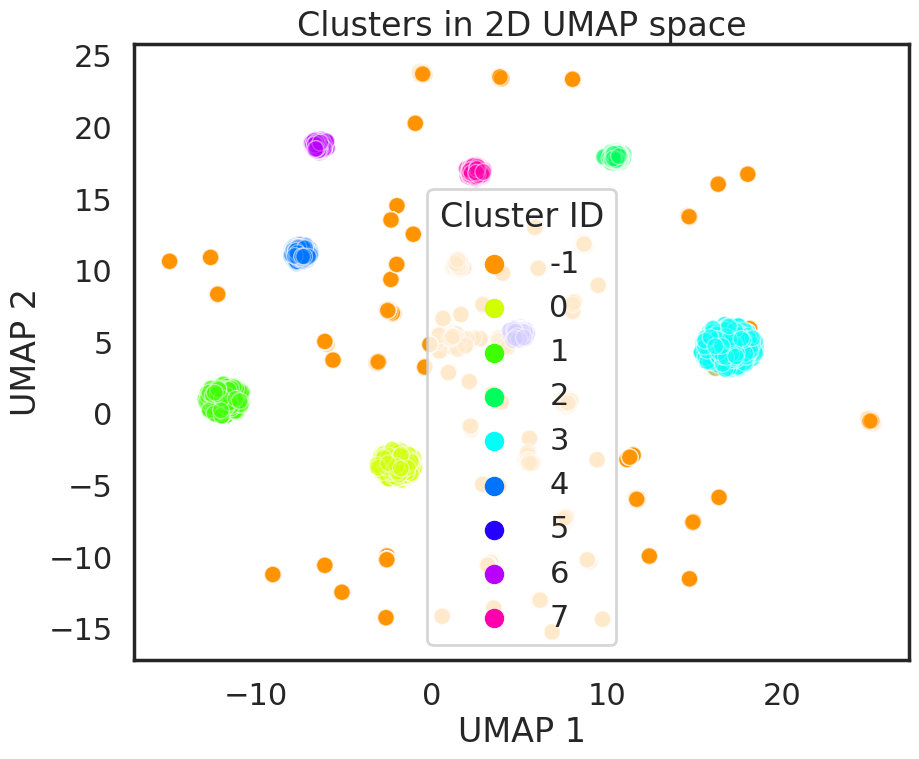

In [159]:
plot_data = pd.DataFrame(data=reduced_all_embeddings, columns=['UMAP 1', 'UMAP 2'])
plot_data['Cluster ID'] = all_clusters  # Add cluster labels to the DataFrame

# Step 2: Plot the data
# Initialize the plot
plt.figure(figsize=(10, 8))

# Use seaborn's scatterplot function to plot UMAP dimensions,
# coloring the points by their cluster ID.
# The 'palette' argument specifies the colors to use for each cluster.
sns.scatterplot(
    x='UMAP 1',  # X-axis: first dimension from UMAP
    y='UMAP 2',  # Y-axis: second dimension from UMAP
    hue='Cluster ID',  # Color by cluster ID
    palette=sns.color_palette("hsv", len(plot_data['Cluster ID'].unique())),  # Use a color palette with enough colors
    data=plot_data,  # Data source
    legend="full",  # Display a legend
    alpha=0.5  # Make points semi-transparent to see overlapping points
)

# Display the plot
plt.title('Clusters in 2D UMAP space')
plt.show()

### Assign Class Labels Back to the DataFrame

Our last step is to assign both a numeric class number and our nominated raw `Journal-ref` label to represent our clusters in the original `node_df` node list `pd.DataFrame`.

In [168]:
node_df = node_df.merge(
    journal_label_df, 
    left_on='Journal-ref-DBSCAN', 
    right_on='Journal-ref-DBSCAN', 
    how='left'
)

# Rename the merged column to the desired name
node_df.rename(
    columns={'Journal-ref-Letters-Cluster': 'Journal-ref-Label'},
    inplace=True
)

In [170]:
node_df[["Title", "Journal-ref", "Journal-ref-Label"]].head(20)

,Title,Journal-ref,Journal-ref-Label
0,"Compactification, Geometry and Duality: N=2",,
1,Generalized Calabi-Yau Manifolds and the Mirro...,Nucl.Phys. B407 (1993) 115-154,Nucl.Phys.
2,"Mirror Symmetry, Mirror Map and Applications t...",Commun.Math.Phys. 167 (1995) 301-350,Class.Quant.Grav
3,"Calabi-Yau Moduli Space, Mirror Manifolds and ...",Nucl.Phys. B416 (1994) 414-480,Nucl.Phys.
4,Measuring Small Distances in N=2 Sigma Models,Nucl.Phys. B420 (1994) 184-242,Nucl.Phys.
5,Target Space Duality in String Theory,Phys.Rept. 244 (1994) 77-202,Class.Quant.Grav
6,String Theory on K3 Surfaces,"Mirror Symmetry II (B. Greene and S.-T. Yau, e...",Class.Quant.Grav
7,"Monopole Condensation, And Confinement In N=2 ...",Nucl.Phys. B426 (1994) 19-52; Erratum-ibid. B4...,Class.Quant.Grav
8,"Monopoles, Duality and Chiral Symmetry Breakin...",Nucl.Phys. B431 (1994) 484-550,Nucl.Phys.
9,Strong/Weak Coupling Duality from the Dual String,Nucl.Phys. B442 (1995) 47-63,Nucl.Phys.


### Save `node_df` to Parquet Format

We want to use this `pd.DataFrame` for new and improved node features for use to learn node classification, so we will save it in Parquet format. I wrote a popular [guide to Python and Parquet format](https://blog.datasyndrome.com/python-and-parquet-performance-e71da65269ce) you may want to check out :)

#### Fix a Small Problem with Empty Strings `""` in the `Published` Column

I got a PyArrow error when I tried to save, so I am filling [imputing] that column with 0s.

```python
ArrowInvalid: ("Could not convert '' with type str: tried to convert to double", 'Conversion failed for column Published with type object')
```

In [183]:
node_df["Published"] = node_df["Published"].replace("", "0").astype(int)
node_df["Published"].head(10)

0    946684800
1            0
2            0
3            0
4            0
5            0
6            0
7            0
8            0
9            0
Name: Published, dtype: int64

#### Lots of Zeros

Hmmmm how many zeros? Enough we may need to find another temporal network or look again at how we parse dates above. Not now :)

In [184]:
node_df["Published"].where(node_df["Published"] == 0).count()

19444

In [185]:
# Make sure we didn't drop any nodes...
len(node_df)

27770

In [186]:
output_df = node_df[[
    "node",
    "file_id",
    "sequential_id",
    "Paper",
    "From",
    "Date",
    "Title",
    "Authors",
    "Comments",
    "Report-no",
    "Published",
    "Journal-ref",
    "Journal-ref-Label",
    "Abstract",
]].fillna("")

In [187]:
output_df.to_parquet("data/cit-HepTh-df.parquet")

## Building K-Nearest-Neighbor Networks

We are going to use the sentence encoded abstracts in `node_df["Abstracts-Paraphrase-Embedding"]` to create a KNN Network.

In [190]:
from sklearn.neighbors import NearestNeighbors

# Convert the embedding column to a 2D numpy array
embeddings = np.vstack(node_df["Abstract-Paraphrase-Embedding"].values)

# Step 1: Compute nearest neighbors
knn = NearestNeighbors(n_neighbors=6, algorithm='auto')  # n_neighbors=6 because the point itself is included
knn.fit(embeddings)
distances, indices = knn.kneighbors(embeddings)

# Step 2: Create a graph from nearest neighbor relationships
KNN_G = nx.Graph()
for i, neighbors in enumerate(indices):
    for neighbor in neighbors[1:]:  # Skip the point itself (neighbors[0] is always the point itself)
        KNN_G.add_edge(i, neighbor)  # Add an edge between the point and each neighbor



Now KNN_G is a graph where each node represents a row in df, and edges connect each node to its k-nearest neighbors.

### Visualizing KNN Networks in Graphistry

Now we will use Graphistry to visualize this network, checking if the edges make sense by comparing nodes' `Title`s and `Abstract`s.

## Building More Scalable Locality Sensitive Hashing (LSH) Networks

This works similarly, but [Locality Sensitive Hashing (LSH)](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) is a more scalable algorithm that hashes data points into buckets such that similar data points are near one another in the same bucket. It is a general purpose operator for creating pairs of nodes in graph machine learning. 

### FAISS

FAISS [[intro here](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/)] is a popular vector search engine from Facebook with an LSH feature

In [ ]:
import faiss
import pandas as pd
import numpy as np
import networkx as nx

# Assume df is your DataFrame and 'sentence_embedding' is the column with embeddings
df = ...  # your DataFrame

# Assume embeddings are stored as lists, so we'll convert to a numpy array
# Also, FAISS requires data to be in float32
embedding_matrix = np.array(df['sentence_embedding'].tolist(), dtype='float32')

# Build the FAISS index
dimension = embedding_matrix.shape[1]  # assuming embedding_matrix is your matrix of embeddings
index = faiss.IndexFlatL2(dimension)
index.add(embedding_matrix)

# Perform the KNN search
k = 6  # Search for 5 nearest neighbors + 1 because the query set is the same as the database
distances, indices = index.search(embedding_matrix, k)

# Construct the network
G = nx.Graph()

# Iterate through each row in the DataFrame
for idx, neighbors in enumerate(indices):
    for neighbor, distance in zip(neighbors[1:], distances[idx][1:]):  # Skip the first neighbor as it will be the node itself
        G.add_edge(df.index[idx], df.index[neighbor], weight=distance)

# Now G is your K-Nearest-Neighbor network!


In [189]:
node_df.columns

Index(['node', 'file_id', 'sequential_id', 'Paper', 'From', 'Date', 'Title',
       'Authors', 'Comments', 'Report-no', 'Published', 'Journal-ref',
       'Abstract', 'Journal-ref-Letters', 'Title-Paraphrase-Embedding',
       'Title-All-Embedding', 'Abstract-Paraphrase-Embedding',
       'Abstract-All-Embedding', 'Journal-ref-Paraphrase-Embedding',
       'Journal-ref-All-Embedding', 'Journal-ref-Letters-Paraphrase-Embedding',
       'Journal-ref-Letters-All-Embedding',
       'Journal-ref-Letters-Paraphrase-KMeans',
       'Journal-ref-Letters-All-KMeans', 'Journal-ref-Letters-All-DBSCAN',
       'Journal-ref-Letters-Paraphrase-DBSCAN', 'Journal-ref-DBSCAN',
       'Journal-ref-Label'],
      dtype='object')